# TO BE DELETED

In [14]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter


In [16]:
import os
import json

# Specify the path to the folder containing JSON files
data_folder_path = '../data/'

# Create an empty dictionary to store data
all_data = {}

# Iterate over all files in the folder
for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        # Form the complete path to the JSON file
        json_file_path = os.path.join(data_folder_path, filename)
        
        # Read the JSON file and store its content in the dictionary
        with open(json_file_path, 'r') as file:
            # Use the filename (without extension) as the key in the dictionary
            all_data[os.path.splitext(filename)[0]] = json.load(file)

# Evolving graphs with nodes of characters and no edges

In [4]:
# # Initialize graph and graph dict to append the graphs
# season_data = all_data["episodes_seasons_characters"]["Naruto: Original"] # Getting the first seasons from the data file
# graph_dict = {}  # Initialize an empty dictionary to store graphs
# count = 1 # Initializing a count

# # Loop over every episode
# for i in range(len(season_data)):
#     G = nx.Graph()  # Create a new graph for each episode
#     characters = season_data[i]["Episode Characters"] # Characters from each episode as a list
    
#     # Add nodes from the previous graph (if it exists). Control statement for the first graph
#     if count > 1:
#         G.add_nodes_from(graph_dict[f'G{count-1}'].nodes) # Getting the nodes (characters) from the previous graph (episode)

#     # Add new characters as nodes
#     if characters is not None: # Control statement if the list of characters is empty/None type
#         G.add_nodes_from(characters) # Adding the characters

#     graph_dict[f'G{count}'] = G # Appending the evolving graph to the dictionary
#     count += 1 # Updating the count

# Evolving undirected graph with nodes as characters and weighted edges

In [19]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    """
    Create a character interaction graph(s) from episode data.

    Parameters:
    - data (dict): Dictionary containing episode data, where keys are season names
                  and values are lists of episode data dictionaries.
    - season (str): If specified, create a character interaction graph for the given season.
                   If None, create graphs for all seasons in the data.
    - characters_info (dict): Dictionary with character attributes to add as node attributes.

    Returns:
    - graph_dict (dict): Dictionary where keys are graph labels (e.g., 'G1') and values
                        are corresponding networkx.Graph instances representing character
                        interaction graphs.
    """

    graph_dict = {} 
    count = 1  

    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  
                characters = episodes_data[i]["Characters"] 

                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  

                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                if characters is not None: 
                    G.add_nodes_from(characters)  

                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  
                count += 1  
    
    else:
        season_data = data[season]  
        graph_dict = {}  
        count = 1  

        for i in range(len(season_data)):
            G = nx.Graph()  
            characters = season_data[i]["Characters"] 

            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  
                
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            if characters is not None:  
                G.add_nodes_from(characters) 

                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  
            count += 1 

    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict


def add_node_attributes(graph, attributes_dict):
    """
    Add node attributes to a graph based on a dictionary.

    Parameters:
    - graph (networkx.Graph): The graph to which attributes will be added.
    - attributes_dict (dict): Dictionary where keys are node names and values are
                              dictionaries containing node attributes.
    """
    
    for node, attributes in attributes_dict.items():
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

In [20]:
graph_dict_first_season = create_character_interaction_graph(all_data["episodes_seasons_characters"], season='Naruto: Original')
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters"])

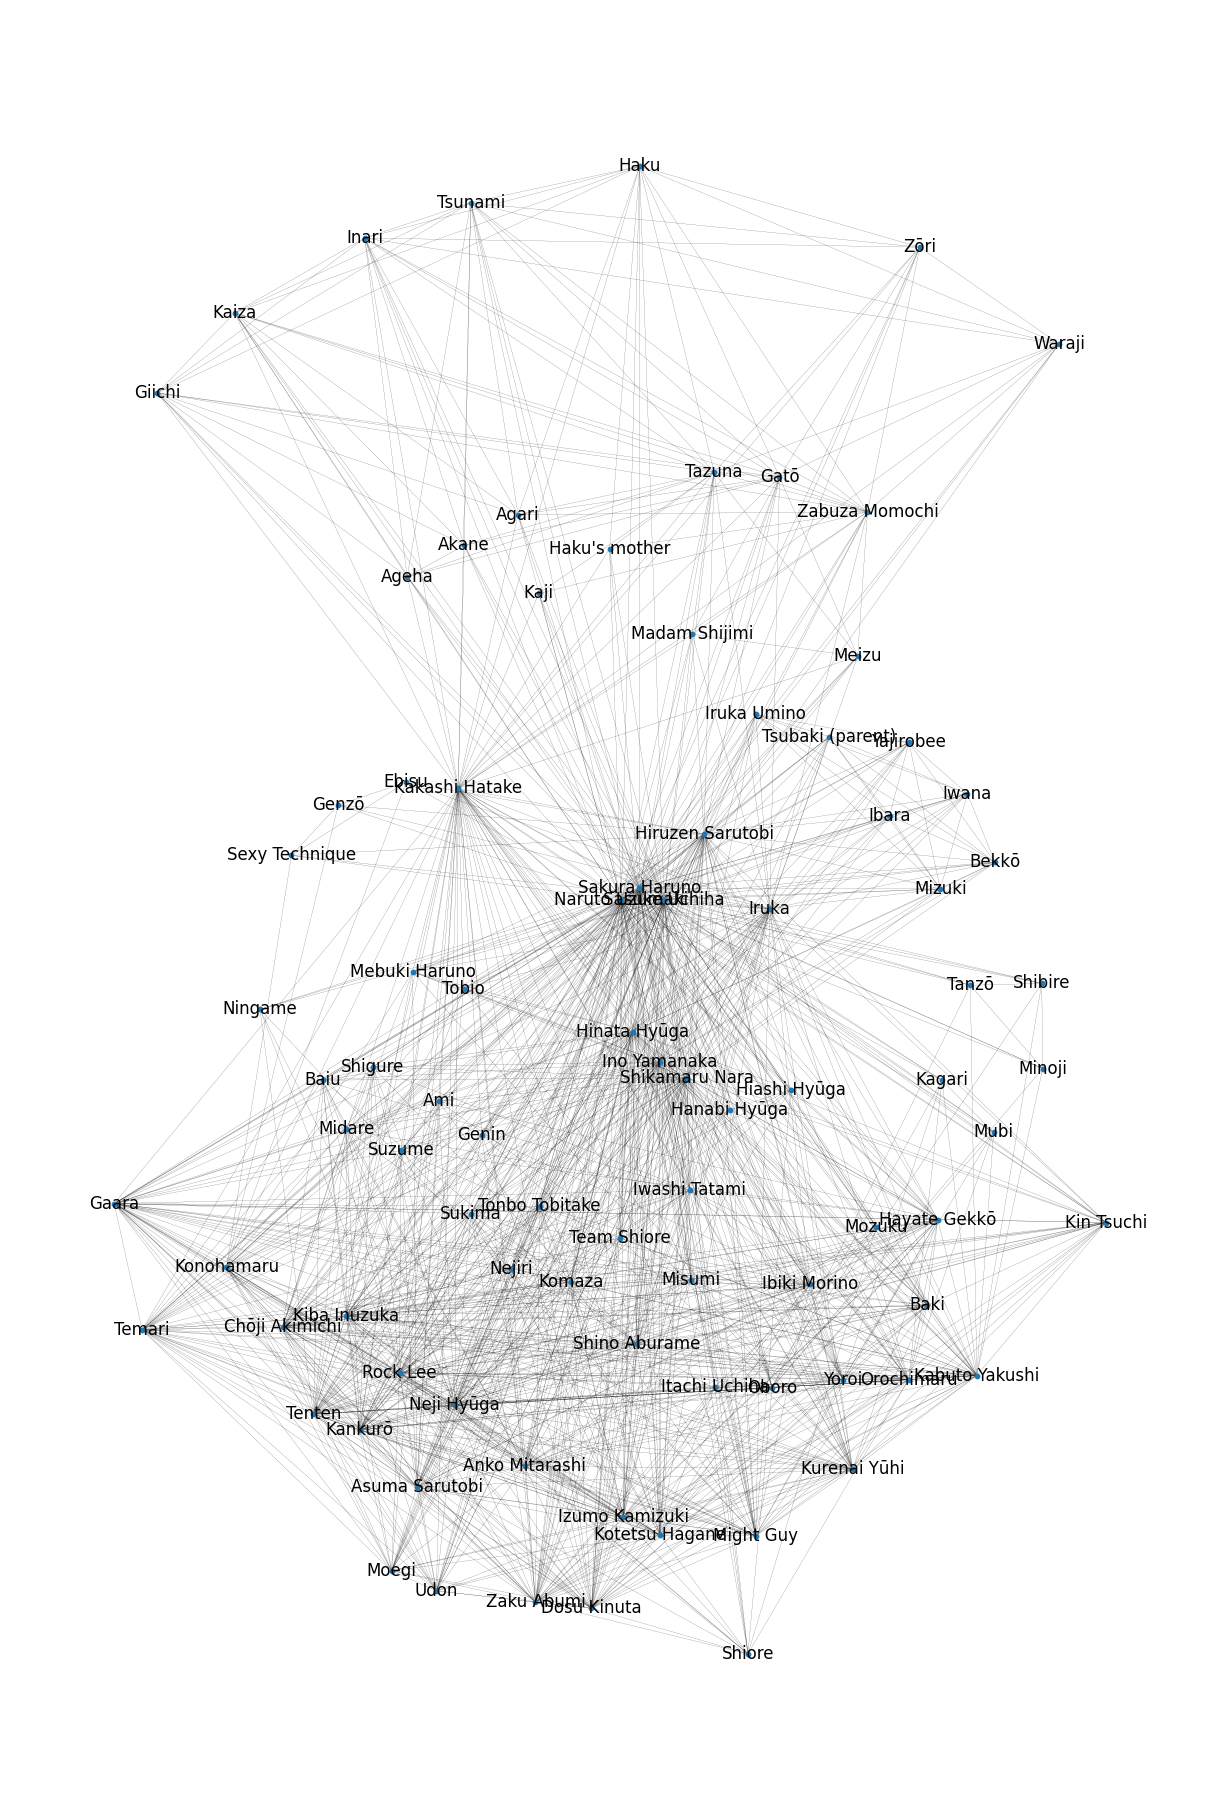

In [22]:
G50 = graph_dict_first_season["G50"]

plt.figure(figsize=(12, 18))
pos = nx.kamada_kawai_layout(G50, scale=8.0) 
nx.draw(G50, pos, node_size= 10, width=0.1, with_labels = True)  

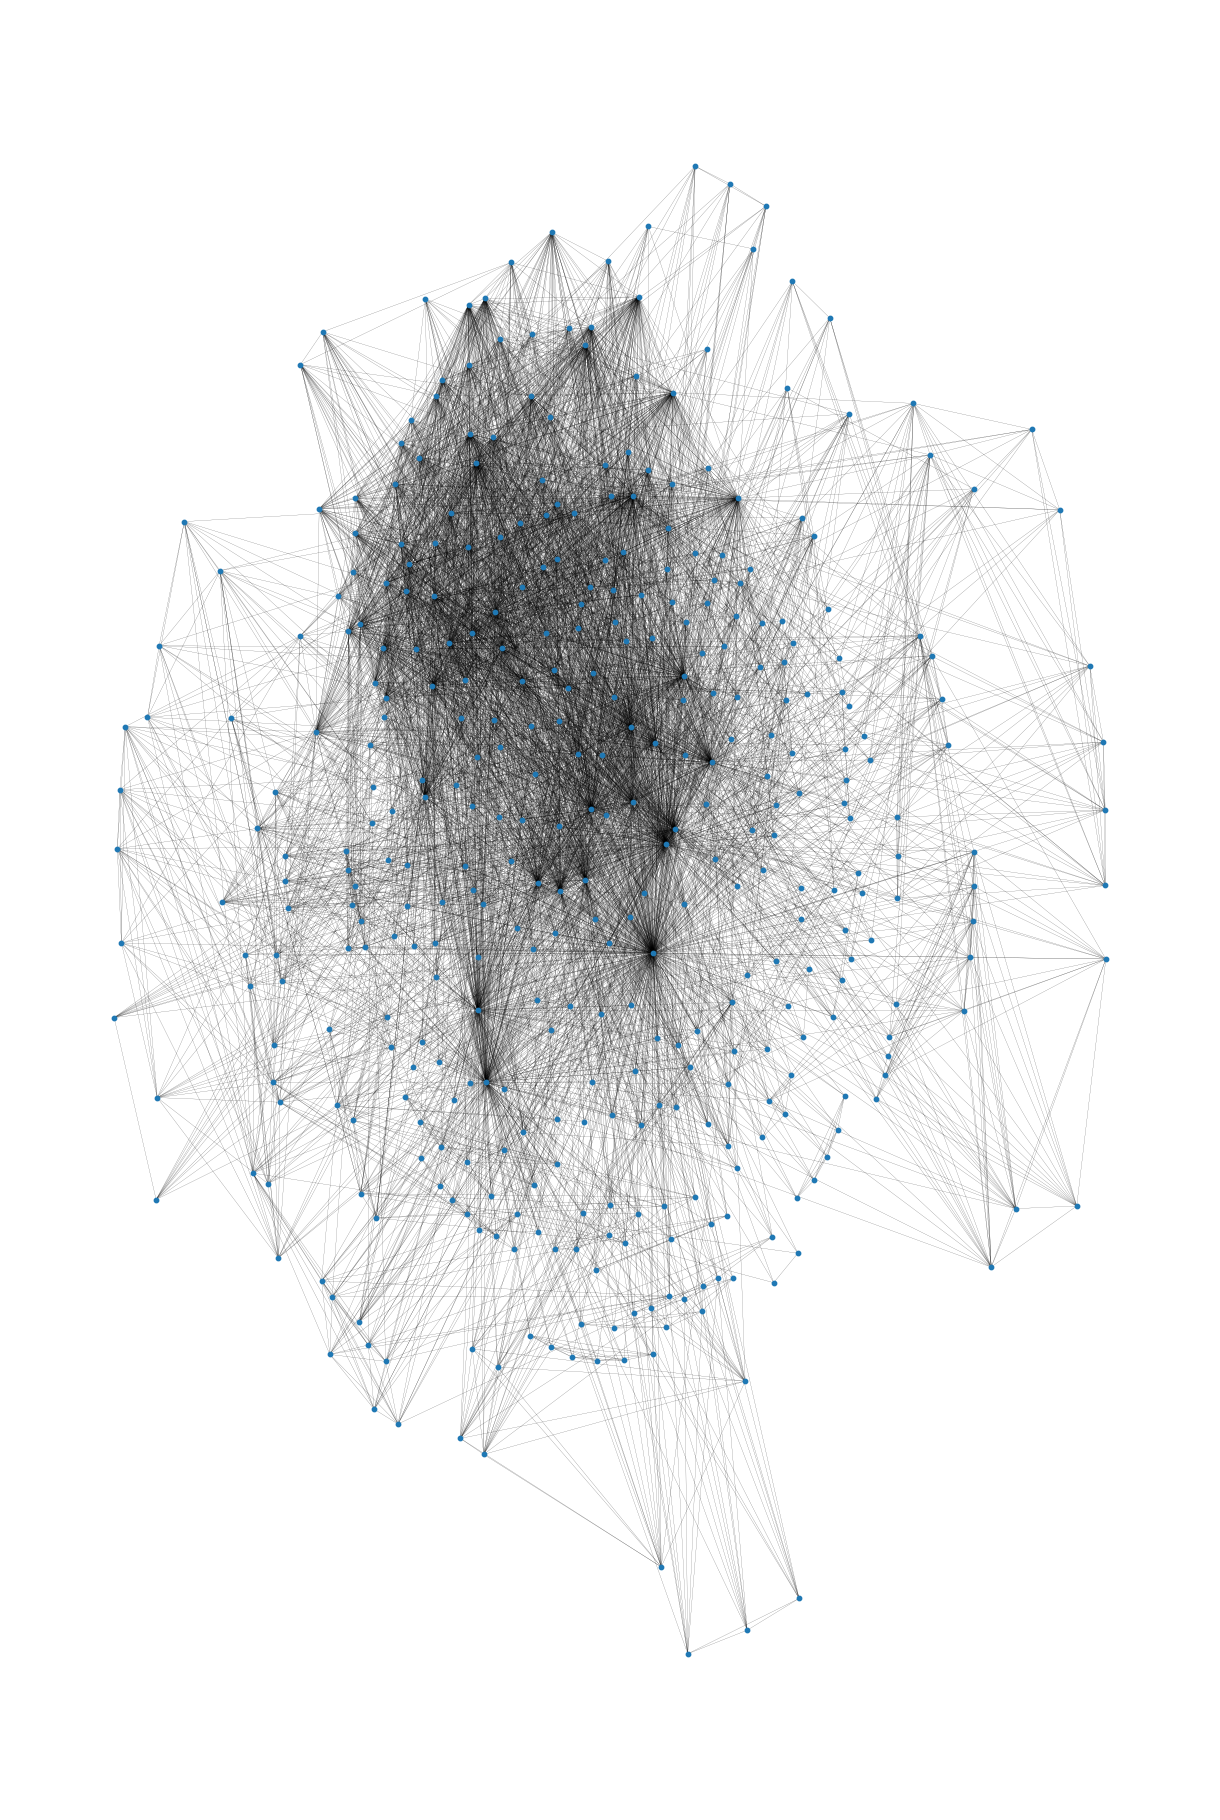

In [8]:
G220 = graph_dict_first_season["G220"]
degree_dict = degrees = dict(G220.degree())

plt.figure(figsize=(12, 18))
pos = nx.kamada_kawai_layout(G220, scale=8.0)  
node_size=[v * 3 for v in degree_dict.values()]
nx.draw(G220, pos, node_size= 10, width=0.1)  

plt.show()

In [9]:
def filter_edges_below_threshold(cumulative_graph, final_graph, threshold):

    """
    Filter edges below a given threshold in a cumulative graph based on final graph weights.

    Parameters:
    - cumulative_graph (networkx.Graph): The cumulative graph containing edges with weights.
    - final_graph (networkx.Graph): The final graph used to determine edge weights.
    - threshold (float): The threshold value below which edges will be removed.

    Returns:
    - filtered_graph (networkx.Graph): A filtered graph with edges above the specified threshold.
    """

    filtered_graph = cumulative_graph.copy()

    # Iterate through edges and remove those below the threshold in the final graph (G1013)
    edges_to_remove = [(u, v) for u, v, w in cumulative_graph.edges(data='weight') if final_graph[u][v]['weight'] < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

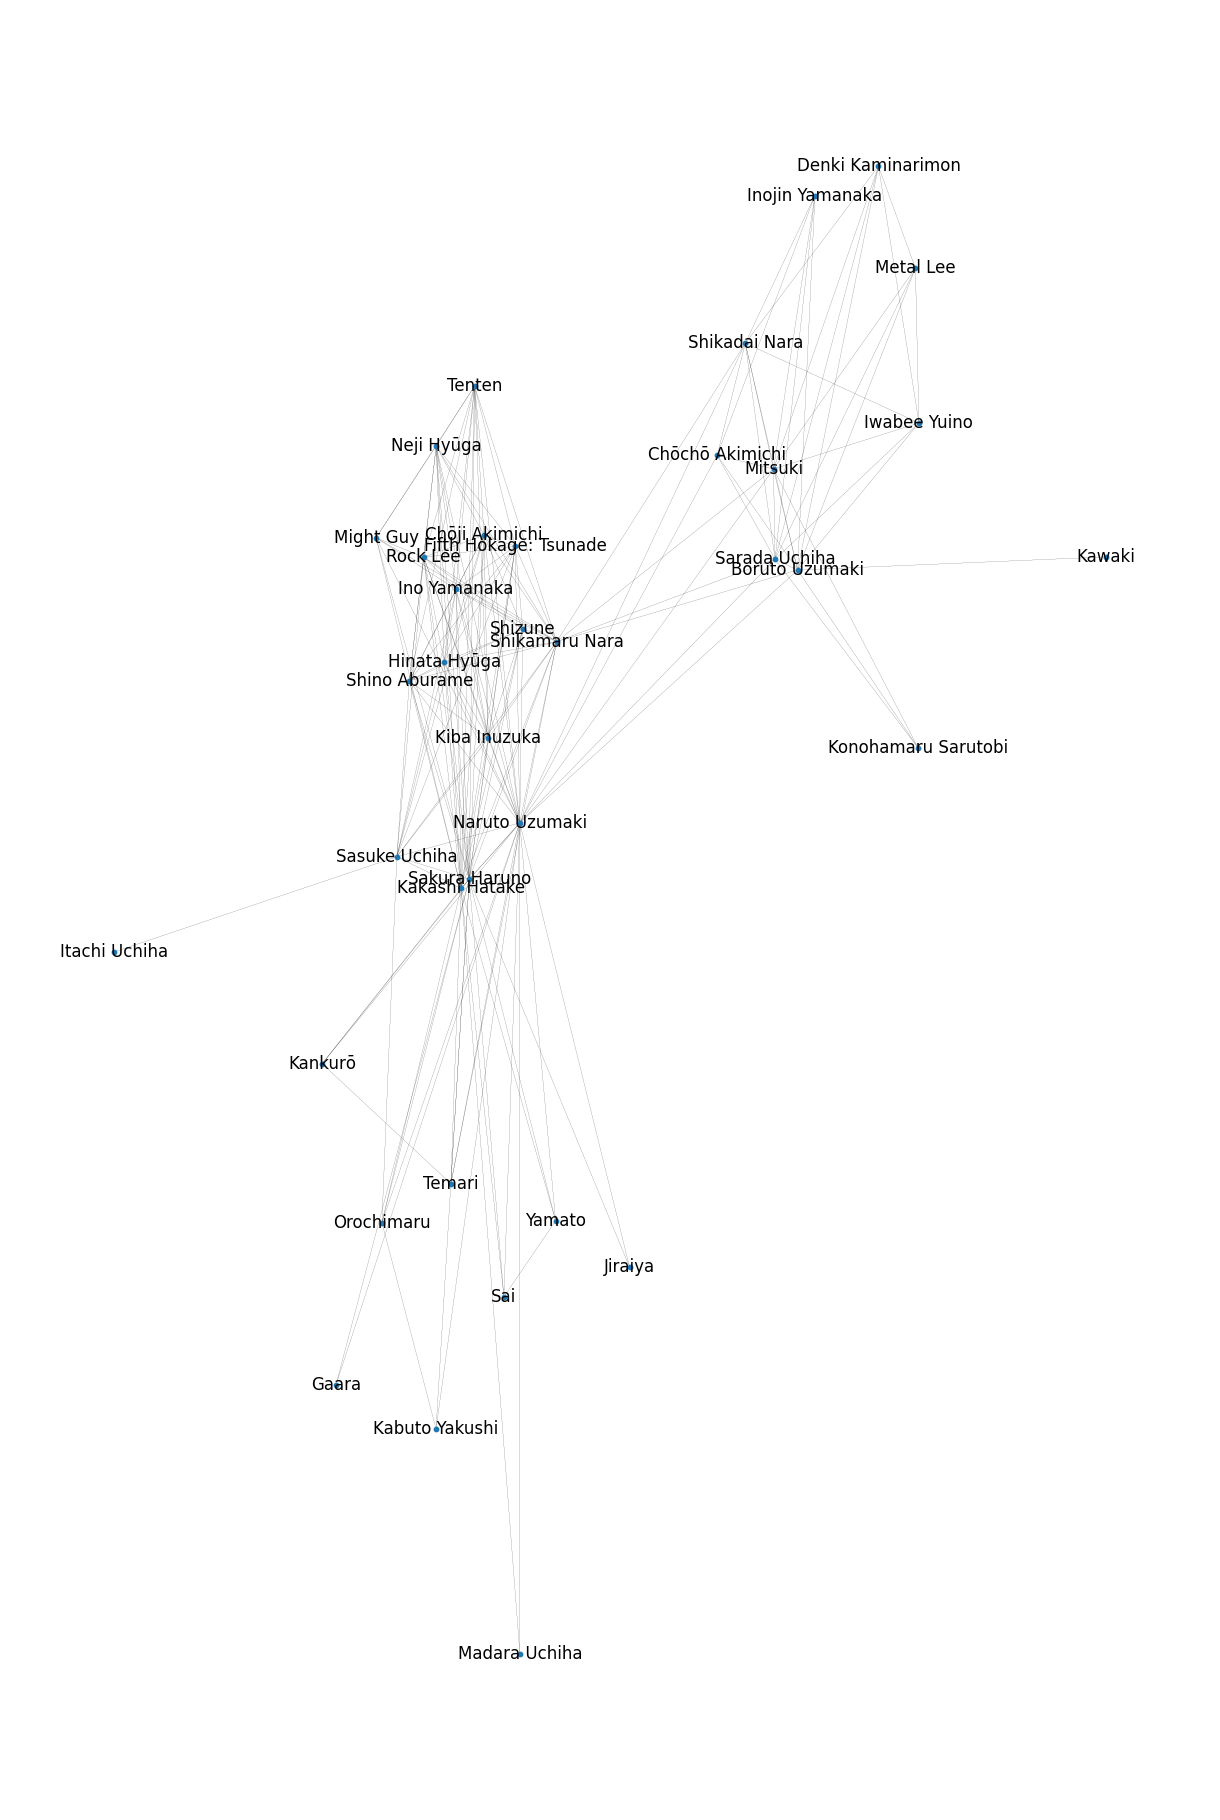

In [13]:
G1013_filtered = filter_edges_below_threshold(graph_dict_all_seasons['G1013'],graph_dict_all_seasons['G1013'], 100)

plt.figure(figsize=(12, 18))
pos = nx.spring_layout(G1013_filtered, scale=8.0)  
nx.draw(G1013_filtered, pos, node_size= 10, width=0.1, with_labels=True)

# Network properties and statistics

## - Degree distribution for the first 2 seaons

In [65]:
# Fetching the dictionaries from season 1 and season 2 respectively
season1 = all_data["episodes_seasons_characters"]["Naruto: Original"] 
season2 = all_data["episodes_seasons_characters"]["Naruto: Shipp\u016bden"]

# Filtering the dictionaries such that season 1 and season 2 merge
keys_to_keep = ['Naruto: Original',"Naruto: Shipp\u016bden"]
filtered_dict_12 = {key: all_data["episodes_seasons_characters"][key] for key in keys_to_keep if key in all_data['episodes_seasons_characters']}

# The dictionary of 720 graphs for first season and for first + second season respectively
graphs_dict_season12 = create_character_interaction_graph(filtered_dict_12)

# --------------------------------------

In [160]:
G20 = graphs_dict_season12["G20"]
degrees_20 = list(dict(G20.degree()).values())

G720 = graphs_dict_season12["G720"]
degrees_720 = list(dict(G720.degree()).values())

In [ ]:
# Defining the values for the loglog plot for the degrees
# Allocating list for the frequency/count of each degree

## -------- FOR GRAPH 1 OF 20 EPISODES -------- ##
frequency20 = []

deg_unique20 = np.unique(degrees_20)

# Counting the frequency for each degree
for degree in deg_unique20:
    count = degrees_20.count(degree)
    frequency.append(count)


## -------- FOR GRAPH 2 OF 720 EPISODES -------- ##
frequency720 = []

deg_unique720 = np.unique(degrees_720)

for degree in deg_unique:
    count = degrees_720.count(degree)
    frequency.append(count)


In [159]:
# Setting the limits for the axis of the distribution plot
# x-axis
min_x_lim = -5
max_x_lim = 50

# y-axis
min_y_lim = 0
max_y_lim = 60

Text(0, 0.5, 'Number of nodes (characters)')

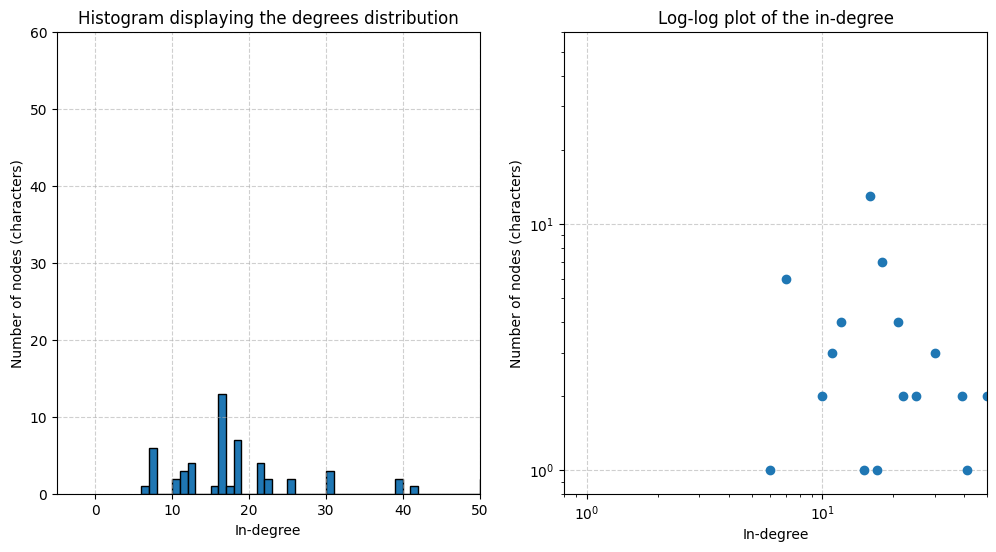

In [162]:
plt.figure(figsize=(12, 6))
############################################## For the histograms ##########################################################
plt.subplot(1, 2, 1)
plt.hist(degrees_20, bins = range(min(degrees_20), max(degrees_20) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title("Histogram displaying the degrees distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

############################################## For the loglog plot ##########################################################
plt.subplot(1, 2, 2)
plt.loglog(deg_unique, frequency, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the in-degree")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

# ---------------------------------------

In [143]:
# Setting the limits for the axis of the distribution plot
# x-axis
min_x_lim = min(degrees_720) - 10
max_x_lim = max(degrees_720) + 5

# y-axis
min_y_lim = 0
max_y_lim = 60

Text(0, 0.5, 'Number of nodes (characters)')

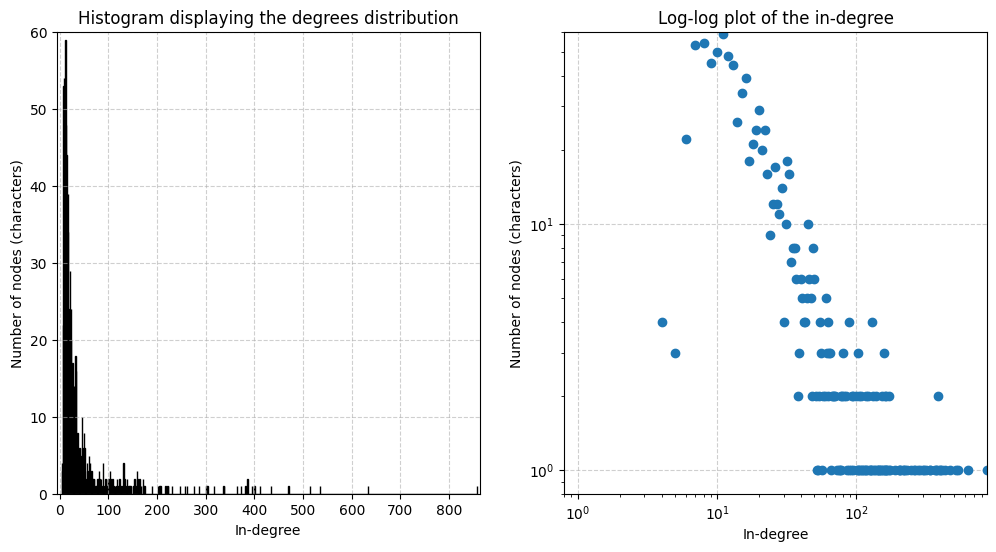

In [156]:
plt.figure(figsize=(12, 6))
############################################## For the histograms ##########################################################
plt.subplot(1, 2, 1)
plt.hist(degrees_720, bins = range(min(degrees_720), max(degrees_720) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title("Histogram displaying the degrees distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

############################################## For the loglog plot ##########################################################
plt.subplot(1, 2, 2)
plt.loglog(deg_unique, frequency, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the in-degree")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (characters)")

In [157]:
# Extracting the exponent
degree_fit = powerlaw.Fit(degrees_720)
degree_exponent = degree_fit.alpha

print("The degree exponent for the degree distribution is:", round(degree_exponent,4))

Calculating best minimal value for power law fit
The degree exponent for the degree distribution is: 2.1431
